In [1]:
from os import listdir, chdir

In [2]:
import sqlite3
import pandas as pd
import numpy as np

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [4]:
def retrieve(c,name):
    query = """SELECT * FROM {}""".format(name) + ";"
    c.execute(query)
    
    rows = c.fetchall()
    data = []
    for row in rows:
        data.append(row)
    return data

In [5]:
chdir('./data')

In [6]:
conn = sqlite3.connect('ETF.db')

c = conn.cursor()

#### Get and Clean Data for 1 stock

In [7]:
a = retrieve(c,'AAAU')

In [12]:
columns = ['Date','Open','High','Low','Close','Adj_Close','Volume']
data = pd.DataFrame(a, columns = columns)
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2018-08-13,11.84,11.84,11.74,11.82,11.82,b'\xc4\xc0\x07\x00\x00\x00\x00\x00'
1,2018-08-20,11.88,12.08,11.85,12.05,12.05,b'\x08\xe9\x04\x00\x00\x00\x00\x00'
2,2018-08-27,12.06,12.13,11.97,12.00,12.00,b'\x94T\x12\x00\x00\x00\x00\x00'
3,2018-09-03,11.91,12.07,11.90,11.96,11.96,b'X\x83\x10\x00\x00\x00\x00\x00'
4,2018-09-10,11.97,12.12,11.88,11.93,11.93,b'\x8ch\x01\x00\x00\x00\x00\x00'


In [16]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
#Convert byte values in Volume to int 
data['Volume'] = [int.from_bytes(value, byteorder = 'little') for value in data['Volume']]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       105 non-null    datetime64[ns]
 1   Open       105 non-null    float64       
 2   High       105 non-null    float64       
 3   Low        105 non-null    float64       
 4   Close      105 non-null    float64       
 5   Adj_Close  105 non-null    float64       
 6   Volume     105 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.9 KB


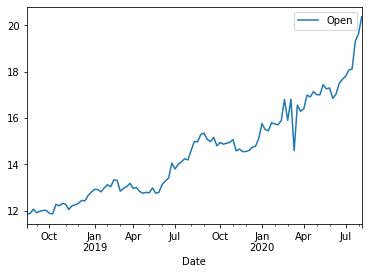

In [25]:
data.plot('Date','Open',kind = 'line')

In [ ]:
adfuller()